# 双向循环神经网络
:label:`sec_bi_rnn`

在序列学习中，我们以往假设的目标是：
在给定观测的情况下
（例如，在时间序列的上下文中或在语言模型的上下文中），
对下一个输出进行建模。
虽然这是一个典型情景，但不是唯一的。
还可能发生什么其它的情况呢？
我们考虑以下三个在文本序列中填空的任务。

* 我`___`。
* 我`___`饿了。
* 我`___`饿了，我可以吃半头猪。

根据可获得的信息量，我们可以用不同的词填空，
如“很高兴”（"happy"）、“不”（"not"）和“非常”（"very"）。
很明显，每个短语的“下文”传达了重要信息（如果有的话），
而这些信息关乎到选择哪个词来填空，
所以无法利用这一点的序列模型将在相关任务上表现不佳。
例如，如果要做好命名实体识别
（例如，识别“Green”指的是“格林先生”还是绿色），
不同长度的上下文范围重要性是相同的。
为了获得一些解决问题的灵感，让我们先迂回到概率图模型。

## 隐马尔可夫模型中的动态规划

这一小节是用来说明动态规划问题的，
具体的技术细节对于理解深度学习模型并不重要，
但它有助于我们思考为什么要使用深度学习，
以及为什么要选择特定的架构。

如果我们想用概率图模型来解决这个问题，
可以设计一个隐变量模型：
在任意时间步$t$，假设存在某个隐变量$h_t$，
通过概率$P(x_t \mid h_t)$控制我们观测到的$x_t$。
此外，任何$h_t \to h_{t+1}$转移
都是由一些状态转移概率$P(h_{t+1} \mid h_{t})$给出。
这个概率图模型就是一个*隐马尔可夫模型*（hidden Markov model，HMM），
如 :numref:`fig_hmm`所示。

![隐马尔可夫模型](../img/hmm.svg)
:label:`fig_hmm`

因此，对于有$T$个观测值的序列，
我们在观测状态和隐状态上具有以下联合概率分布：

$$P(x_1, \ldots, x_T, h_1, \ldots, h_T) = \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t), \text{ where } P(h_1 \mid h_0) = P(h_1).$$
:eqlabel:`eq_hmm_jointP`

现在，假设我们观测到所有的$x_i$，除了$x_j$，
并且我们的目标是计算$P(x_j \mid x_{-j})$，
其中$x_{-j} = (x_1, \ldots, x_{j-1}, x_{j+1}, \ldots, x_{T})$。
由于$P(x_j \mid x_{-j})$中没有隐变量，
因此我们考虑对$h_1, \ldots, h_T$选择构成的
所有可能的组合进行求和。
如果任何$h_i$可以接受$k$个不同的值（有限的状态数），
这意味着我们需要对$k^T$个项求和，
这个任务显然难于登天。
幸运的是，有个巧妙的解决方案：*动态规划*（dynamic programming）。

要了解动态规划的工作方式，
我们考虑对隐变量$h_1, \ldots, h_T$的依次求和。
根据 :eqref:`eq_hmm_jointP`，将得出：

$$\begin{aligned}
    &P(x_1, \ldots, x_T) \\
    =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_2, \ldots, h_T} \underbrace{\left[\sum_{h_1} P(h_1) P(x_1 \mid h_1) P(h_2 \mid h_1)\right]}_{\pi_2(h_2) \stackrel{\mathrm{def}}{=}}
    P(x_2 \mid h_2) \prod_{t=3}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t) \\
    =& \sum_{h_3, \ldots, h_T} \underbrace{\left[\sum_{h_2} \pi_2(h_2) P(x_2 \mid h_2) P(h_3 \mid h_2)\right]}_{\pi_3(h_3)\stackrel{\mathrm{def}}{=}}
    P(x_3 \mid h_3) \prod_{t=4}^T P(h_t \mid h_{t-1}) P(x_t \mid h_t)\\
    =& \dots \\
    =& \sum_{h_T} \pi_T(h_T) P(x_T \mid h_T).
\end{aligned}$$

通常，我们将*前向递归*（forward recursion）写为：

$$\pi_{t+1}(h_{t+1}) = \sum_{h_t} \pi_t(h_t) P(x_t \mid h_t) P(h_{t+1} \mid h_t).$$

递归被初始化为$\pi_1(h_1) = P(h_1)$。
符号简化，也可以写成$\pi_{t+1} = f(\pi_t, x_t)$，
其中$f$是一些可学习的函数。
这看起来就像我们在循环神经网络中讨论的隐变量模型中的更新方程。

与前向递归一样，我们也可以使用后向递归对同一组隐变量求和。这将得到：

$$\begin{aligned}
    & P(x_1, \ldots, x_T) \\
     =& \sum_{h_1, \ldots, h_T} P(x_1, \ldots, x_T, h_1, \ldots, h_T) \\
    =& \sum_{h_1, \ldots, h_T} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot P(h_T \mid h_{T-1}) P(x_T \mid h_T) \\
    =& \sum_{h_1, \ldots, h_{T-1}} \prod_{t=1}^{T-1} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_T} P(h_T \mid h_{T-1}) P(x_T \mid h_T)\right]}_{\rho_{T-1}(h_{T-1})\stackrel{\mathrm{def}}{=}} \\
    =& \sum_{h_1, \ldots, h_{T-2}} \prod_{t=1}^{T-2} P(h_t \mid h_{t-1}) P(x_t \mid h_t) \cdot
    \underbrace{\left[\sum_{h_{T-1}} P(h_{T-1} \mid h_{T-2}) P(x_{T-1} \mid h_{T-1}) \rho_{T-1}(h_{T-1}) \right]}_{\rho_{T-2}(h_{T-2})\stackrel{\mathrm{def}}{=}} \\
    =& \ldots \\
    =& \sum_{h_1} P(h_1) P(x_1 \mid h_1)\rho_{1}(h_{1}).
\end{aligned}$$

因此，我们可以将*后向递归*（backward recursion）写为：

$$\rho_{t-1}(h_{t-1})= \sum_{h_{t}} P(h_{t} \mid h_{t-1}) P(x_{t} \mid h_{t}) \rho_{t}(h_{t}),$$

初始化$\rho_T(h_T) = 1$。
前向和后向递归都允许我们对$T$个隐变量在$\mathcal{O}(kT)$
（线性而不是指数）时间内对$(h_1, \ldots, h_T)$的所有值求和。
这是使用图模型进行概率推理的巨大好处之一。
它也是通用消息传递算法 :cite:`Aji.McEliece.2000`的一个非常特殊的例子。
结合前向和后向递归，我们能够计算

$$P(x_j \mid x_{-j}) \propto \sum_{h_j} \pi_j(h_j) \rho_j(h_j) P(x_j \mid h_j).$$

因为符号简化的需要，后向递归也可以写为$\rho_{t-1} = g(\rho_t, x_t)$，
其中$g$是一个可以学习的函数。
同样，这看起来非常像一个更新方程，
只是不像我们在循环神经网络中看到的那样前向运算，而是后向计算。
事实上，知道未来数据何时可用对隐马尔可夫模型是有益的。
信号处理学家将是否知道未来观测这两种情况区分为内插和外推，
有关更多详细信息，请参阅 :cite:`Doucet.De-Freitas.Gordon.2001`。

## 双向模型

如果我们希望在循环神经网络中拥有一种机制，
使之能够提供与隐马尔可夫模型类似的前瞻能力，
我们就需要修改循环神经网络的设计。
幸运的是，这在概念上很容易，
只需要增加一个“从最后一个词元开始从后向前运行”的循环神经网络，
而不是只有一个在前向模式下“从第一个词元开始运行”的循环神经网络。
*双向循环神经网络*（bidirectional RNNs）
添加了反向传递信息的隐藏层，以便更灵活地处理此类信息。
 :numref:`fig_birnn`描述了具有单个隐藏层的双向循环神经网络的架构。

![双向循环神经网络架构](../img/birnn.svg)
:label:`fig_birnn`

事实上，这与隐马尔可夫模型中的动态规划的前向和后向递归没有太大区别。
其主要区别是，在隐马尔可夫模型中的方程具有特定的统计意义。
双向循环神经网络没有这样容易理解的解释，
我们只能把它们当作通用的、可学习的函数。
这种转变集中体现了现代深度网络的设计原则：
首先使用经典统计模型的函数依赖类型，然后将其参数化为通用形式。

### 定义

双向循环神经网络是由 :cite:`Schuster.Paliwal.1997`提出的，
关于各种架构的详细讨论请参阅 :cite:`Graves.Schmidhuber.2005`。
让我们看看这样一个网络的细节。

对于任意时间步$t$，给定一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数$n$，每个示例中的输入数$d$），
并且令隐藏层激活函数为$\phi$。
在双向架构中，我们设该时间步的前向和反向隐状态分别为
$\overrightarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$和
$\overleftarrow{\mathbf{H}}_t  \in \mathbb{R}^{n \times h}$，
其中$h$是隐藏单元的数目。
前向和反向隐状态的更新如下：

$$
\begin{aligned}
\overrightarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(f)} + \overrightarrow{\mathbf{H}}_{t-1} \mathbf{W}_{hh}^{(f)}  + \mathbf{b}_h^{(f)}),\\
\overleftarrow{\mathbf{H}}_t &= \phi(\mathbf{X}_t \mathbf{W}_{xh}^{(b)} + \overleftarrow{\mathbf{H}}_{t+1} \mathbf{W}_{hh}^{(b)}  + \mathbf{b}_h^{(b)}),
\end{aligned}
$$

其中，权重$\mathbf{W}_{xh}^{(f)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(f)} \in \mathbb{R}^{h \times h}, \mathbf{W}_{xh}^{(b)} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh}^{(b)} \in \mathbb{R}^{h \times h}$
和偏置$\mathbf{b}_h^{(f)} \in \mathbb{R}^{1 \times h}, \mathbf{b}_h^{(b)} \in \mathbb{R}^{1 \times h}$都是模型参数。

接下来，将前向隐状态$\overrightarrow{\mathbf{H}}_t$
和反向隐状态$\overleftarrow{\mathbf{H}}_t$连接起来，
获得需要送入输出层的隐状态$\mathbf{H}_t \in \mathbb{R}^{n \times 2h}$。
在具有多个隐藏层的深度双向循环神经网络中，
该信息作为输入传递到下一个双向层。
最后，输出层计算得到的输出为
$\mathbf{O}_t \in \mathbb{R}^{n \times q}$（$q$是输出单元的数目）：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

这里，权重矩阵$\mathbf{W}_{hq} \in \mathbb{R}^{2h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$
是输出层的模型参数。
事实上，这两个方向可以拥有不同数量的隐藏单元。

### 模型的计算代价及其应用

双向循环神经网络的一个关键特性是：使用来自序列两端的信息来估计输出。
也就是说，我们使用来自过去和未来的观测信息来预测当前的观测。
但是在对下一个词元进行预测的情况中，这样的模型并不是我们所需的。
因为在预测下一个词元时，我们终究无法知道下一个词元的下文是什么，
所以将不会得到很好的精度。
具体地说，在训练期间，我们能够利用过去和未来的数据来估计现在空缺的词；
而在测试期间，我们只有过去的数据，因此精度将会很差。
下面的实验将说明这一点。

另一个严重问题是，双向循环神经网络的计算速度非常慢。
其主要原因是网络的前向传播需要在双向层中进行前向和后向递归，
并且网络的反向传播还依赖于前向传播的结果。
因此，梯度求解将有一个非常长的链。

双向层的使用在实践中非常少，并且仅仅应用于部分场合。
例如，填充缺失的单词、词元注释（例如，用于命名实体识别）
以及作为序列处理流水线中的一个步骤对序列进行编码（例如，用于机器翻译）。
在 :numref:`sec_bert`和 :numref:`sec_sentiment_rnn`中，
我们将介绍如何使用双向循环神经网络编码文本序列。

## (**双向循环神经网络的错误应用**)

由于双向循环神经网络使用了过去的和未来的数据，
所以我们不能盲目地将这一语言模型应用于任何预测任务。
尽管模型产出的困惑度是合理的，
该模型预测未来词元的能力却可能存在严重缺陷。
我们用下面的示例代码引以为戒，以防在错误的环境中使用它们。


In [1]:
import torch

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [2]:
import re
import requests
import os
import collections
import random
import torch

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def download_time_machine(data_dir='../data', filename='timemachine.txt'):
    """下载时间机器文本文件"""
    url = 'http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'
    
    # 创建数据目录（如果不存在）
    os.makedirs(data_dir, exist_ok=True)
    
    # 完整文件路径
    file_path = os.path.join(data_dir, filename)
    
    # 如果文件不存在，则下载
    if not os.path.exists(file_path):
        print(f'Downloading {filename} from {url}...')
        response = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f'File saved to {file_path}')
    else:
        print(f'File already exists at {file_path}')
    
    return file_path

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    # 下载文件并获取路径
    file_path = download_time_machine()
    
    # 读取文件内容
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # 处理每一行：只保留字母，转为小写，去除首尾空格
    processed_lines = [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
    
    return processed_lines

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab


In [4]:
from torch.nn import functional as F
import torch.nn as nn

#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [5]:
import time
import numpy as np
import math
import torch

class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, Timer()
    metric = Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [6]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

from IPython import display
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        
        # 替换 d2l.use_svg_display()
        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = figsize
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 替换 d2l.set_axes，使用 lambda 函数直接配置参数
        self.config_axes = lambda: self._set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def _set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """设置坐标轴标签、范围和比例"""
        import matplotlib.pyplot as plt
        # 设置坐标轴标签
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        # 设置坐标轴范围
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        # 设置坐标轴比例
        if xscale:
            ax.set_xscale(xscale)
        if yscale:
            ax.set_yscale(yscale)
        # 设置图例
        if legend:
            ax.legend(legend)
        # 添加网格
        ax.grid(True)

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.2, 10140.5 词元/秒 cpu
time travellerlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlr
travellerererrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


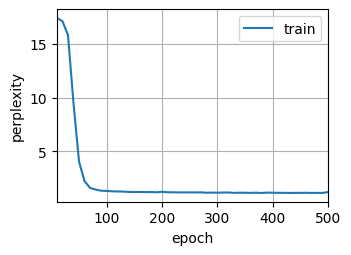

In [7]:
import torch
from torch import nn
# from d2l import torch as d2l

# 加载数据
batch_size, num_steps, device = 32, 35, try_gpu()
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
# 通过设置“bidirective=True”来定义双向LSTM模型
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

上述结果显然令人瞠目结舌。
关于如何更有效地使用双向循环神经网络的讨论，
请参阅 :numref:`sec_sentiment_rnn`中的情感分类应用。

## 小结

* 在双向循环神经网络中，每个时间步的隐状态由当前时间步的前后数据同时决定。
* 双向循环神经网络与概率图模型中的“前向-后向”算法具有相似性。
* 双向循环神经网络主要用于序列编码和给定双向上下文的观测估计。
* 由于梯度链更长，因此双向循环神经网络的训练代价非常高。

## 练习

1. 如果不同方向使用不同数量的隐藏单位，$\mathbf{H_t}$的形状会发生怎样的变化？
1. 设计一个具有多个隐藏层的双向循环神经网络。
1. 在自然语言中一词多义很常见。例如，“bank”一词在不同的上下文“i went to the bank to deposit cash”和“i went to the bank to sit down”中有不同的含义。如何设计一个神经网络模型，使其在给定上下文序列和单词的情况下，返回该单词在此上下文中的向量表示？哪种类型的神经网络架构更适合处理一词多义？


[Discussions](https://discuss.d2l.ai/t/2773)
